# Machine Learning to classify and remove badly segmented *Escherichia coli* cells

This notebook provides all the nessecary information to succesfully implement supervised classification of segmented cells, to identigy and remove the badly segmented cells. A linear SVM model will be used for that purpose and cellular features extracted from the binary cell masks. 


## Extracting cellular features

Different cellular features were used to train the SVM model. These features are based on the morphology of the segmented cell mask and the fitted central line (medial axis). The medial axis definition is also provided in my Image-analysis repository:


Features
1. cell_area: the area of the cell mask in pixels.
2. cell_length: the arch length of the fitted central line.
3. max_distance: the maximum distance of the cell mask pixels from the central line (the projection of each pixel is considered).
4. cell_angle: the angle formed by 3 points (pole, center of mass, pole).
5. sinuosity: the length of the central line divided by the length of a line connecting the two poles or the first and the last point of the medial axis.
6. central_intercept: the point were a line that connects the two poles intersects the central line.
7. constriction: the reduction of cell width around the cell center (position determined by a trough finder) relative the entire cell width.

Since one central line is fitted per cell mask, wrong masks including more than one cells will have aberrant cell_area/cell_length ratios. The max_distance will also be unusually high.

The cell angle helps excluded cell masks which include two cells after division. These two cells are likely to form a 90-degree angle. Normal cells will have an angle around 180 degrees. WARNING, this feature does not work for elongated/filamentous cells which can achieve all possible cell angles even prior to division.

Similarly to the cell_angle, the central_intercept helps detect cell masks which include two cells after division. E. coli cells are usually rod-shaped with a little bit of curvature. For these normal-looking cells, the line connceting the poles should not intersect the central line. An s-shaped central line usually indicates divided cells and the central_intercept should be located around the center of mass of the cell mask.

The sinuosity is a measure of the curvature of the central line. It is also included as a cell feature for training the SVM model.


#### The cell_angle feature 

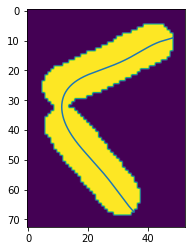

#### The max_distance feature

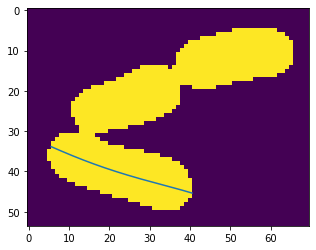

#### The central_intercept feature

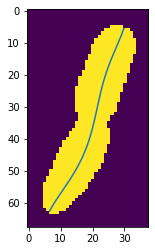

In [1]:
# importing libraries and functions
import pandas as pd
import os
import sys
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix, f1_score, jaccard_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
# includes all functions used for the analysis of the Brownian statistics
# module_path = os.path.abspath(os.path.join('..'))
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), "/train_the_svm.py"))
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), "/ml_rediction.py"))
import train_the_svm as tsvm
import ml_prediction as mlp

## Generation of a training dataset

The cell_feature_extraction_functions.py and the 
create_a_training_dataset.py functions and script were used to generate the training dataset.
It takes a long time to extract the cell features and generate the training dataset.

The functions and script are saved here:
"godmother\shared_data\Alex\cell_mesh_classification_ML\cell_feature_extraction_functions.py"
"godmother\shared_data\Alex\cell_mesh_classification_ML\create_a_training_dataset.py"

The training dataset is saved here:
"godmother\shared_data\Alex\cell_mesh_classification_ML\training_data"

In [3]:
train_df = pd.read_csv('training_data')
print(train_df.describe())
print(train_df.shape[0], 'cells manually classified to construct this training dataset')

         Unnamed: 0     cell_area   cell_length  max_distance    cell_angle  \
count  34863.000000  34863.000000  34626.000000  34626.000000  34623.000000   
mean    4602.699165    544.880045     43.504288      7.542491    175.345703   
std     2840.103318    136.753687     10.302559      1.444424      6.103302   
min        0.000000    104.000000     13.180933      5.370972      0.014440   
25%     2178.500000    441.000000     35.488948      7.183800    173.621281   
50%     4357.000000    528.000000     41.972541      7.462959    176.543763   
75%     6978.000000    630.000000     50.200062      7.750840    178.446981   
max    10397.000000   1644.000000    140.848981     48.777833    180.000000   

          sinuosity  constriction  central_intercept         class  
count  34626.000000  34626.000000       34626.000000  34863.000000  
mean       1.172052      0.054546           0.871349      0.980466  
std       20.114856      0.134985           0.266931      0.138393  
min        1

## Training the SVM model

A linear SVM model will be trained on the training data. The training data include both the untreated exponentially growing cells and cells treated with LL37 (experiment performed on 10.26.2021: cell_id includes '20211026').

Since only a small percentage of cells are badly segmented (around 1-10% depending on the density and condition), the SVM model will be weighted by the number of cells in each class (good vs bad segmentations).


In [ ]:

svm_model = tsvm.train_svm_model(train_df, features_=['cell_area', 'cell_length', 'constriction', 'max_distance', 'cell_angle', 'central_intercept'], 
                            kernel_='linear', weight=True, test_size_=0.3)


Please wait. Weighted optimization takes time...
Train set: (24236, 6) (24236,)
Test set: (10387, 6) (10387,)


The model has been chosen to be faithfully remove badly segmented cells, at the expense of good cells. It ensures that very small numbers of bad cells remain in the dataset. As a result, only 21 badly segmented cells (true label) remain in the 9296 classified good cells (predicted label). That's a very small percentage pf 0.2%.

## Using the linear weighted SVM models for predictions

The trained linear SVM model will be used for predictions


In [ ]:
good_cells, bad_cells, prediction_df = mlp.supervised_prediction(
                                                    train_df, 
                                                    trained_model=svm_model,
                                                    features_=['cell_area', 'cell_length', 'constriction', 'max_distance', 'cell_angle', 'central_intercept']
                                                    )
